In [49]:
import Random
Random.seed!(0)
pwd()

"/home/bach/iskra"

In [50]:
include("problem/units_and_constants.jl")
include("problem/configuration.jl")
config = Config();

In [51]:
nx = 20         # number of nodes in x direction
ny = 20         # number of nodes in y direction
ts = 500        # number of time steps
Δh = 5cm        # cell size
Δt = 20ns       # time step
Lx = nx*Δh      # domain length in x direction
Ly = ny*Δh      # domain length in y direction
nothing

In [52]:
xs, ys = 0m:Δh:Lx, 0m:Δh:Ly
sx, sv = [0 Lx; 0 Ly], [0 -0.05Δh/Δt; 0 0]
e = create_kinetic_species("e-", 20_000,-1qe, 1me, 1);
γ = create_gamma_ionization_source(1/Δt, sx, sv);

In [53]:
import RegularGrid, FiniteDifferenceMethod, ParticleInCell
config.grid    = RegularGrid.create_uniform_grid(xs, ys)
config.cells   = RegularGrid.create_staggered_grid(config.grid)
config.solver  = FiniteDifferenceMethod.create_poisson_solver(config.grid, ε0)
config.pusher  = ParticleInCell.create_boris_pusher()
config.tracker = ParticleInCell.create_surface_tracker(config.grid, ParticleInCell.PeriodicSurface())
config.species = [e];

In [54]:
nx, ny = size(config.grid)
mx, my = size(config.cells)
εr  = ones(mx, my, 1)
bcs = zeros(Int8, nx, ny, 1)
bcs[ nx,  1, 1] = 1
bcs[ nx, ny, 1] = 2
set_permittivity(εr)
create_electrode(bcs .== 1, config; σ=1ε0);
create_electrode(bcs .== 2, config; fixed=true);

In [55]:
using Diagnostics

function ParticleInCell.after_loop(i, t, dt)
  new_iteration("01_single_particle", i, t, dt) do it
    save_diagnostic(it, "e-/positionOffset/x")
    save_diagnostic(it, "e-/positionOffset/y")
    save_diagnostic(it, "e-/positionOffset/z")
    save_diagnostic(it, "e-/position")
    save_diagnostic(it, "e-/momentum")
    save_diagnostic(it, "e-/weighting")
    save_diagnostic(it, "e-/charge")
    save_diagnostic(it, "e-/mass")
    save_diagnostic(it, "e-/id")
    save_diagnostic(it, "rho")
    save_diagnostic(it, "phi")
    save_diagnostic(it, "E")
  end
end

nothing

In [56]:
ParticleInCell.init(γ, e, Δt)
@time ParticleInCell.solve(config, Δt, ts)

Time Step #1
Time Step #2
Time Step #3
Time Step #4
Time Step #5
Time Step #6
Time Step #7
Time Step #8
Time Step #9
Time Step #10
Time Step #11
Time Step #12
Time Step #13
Time Step #14
Time Step #15
Time Step #16
Time Step #17
Time Step #18
Time Step #19
Time Step #20
Time Step #21
Time Step #22
Time Step #23
Time Step #24
Time Step #25
Time Step #26
Time Step #27
Time Step #28
Time Step #29
Time Step #30
Time Step #31
Time Step #32
Time Step #33
Time Step #34
Time Step #35
Time Step #36
Time Step #37
Time Step #38
Time Step #39
Time Step #40
Time Step #41
Time Step #42
Time Step #43
Time Step #44
Time Step #45
Time Step #46
Time Step #47
Time Step #48
Time Step #49
Time Step #50
Time Step #51
Time Step #52
Time Step #53
Time Step #54
Time Step #55
Time Step #56
Time Step #57
Time Step #58
Time Step #59
Time Step #60
Time Step #61
Time Step #62
Time Step #63
Time Step #64
Time Step #65
Time Step #66
Time Step #67
Time Step #68
Time Step #69
Time Step #70
Time Step #71
Time Step #72
T

### Analysis

In [57]:
using PyPlot
using PyCall
ov = pyimport("openpmd_viewer")
ts = ov.OpenPMDTimeSeries("/tmp/01_single_particle/hdf5");

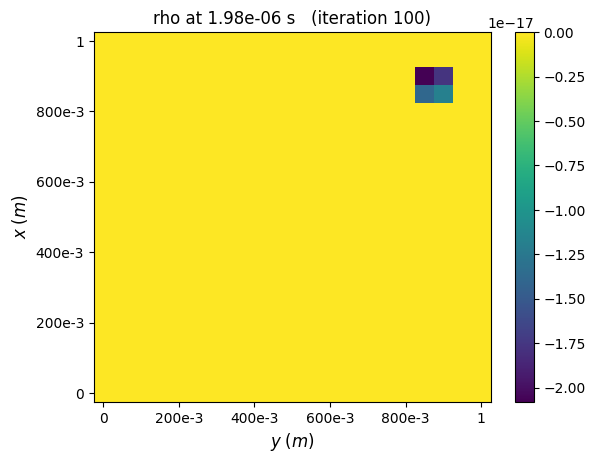

In [58]:
ts.get_field("rho", iteration=100, plot=true);

In [59]:
pt = ov.ParticleTracker(ts, iteration=1, select=Dict("id"=>[0,1]),
    species="e-", preserve_particle_index=false)
it, np = length(ts.iterations), pt.N_selected;

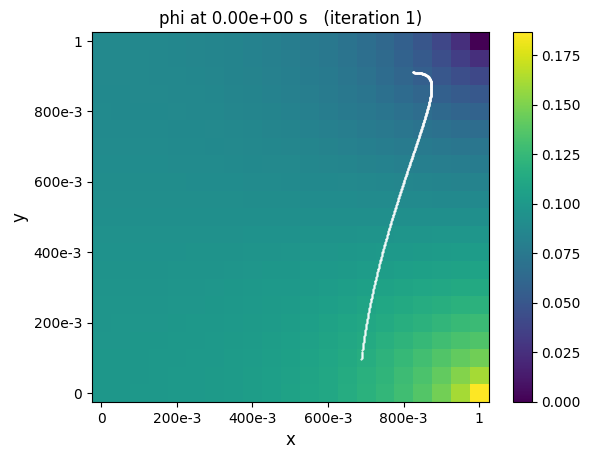

In [60]:
px_trajectories = zeros(it, np)
py_trajectories = zeros(it, np)
ux_trajectories = zeros(it, np)
uy_trajectories = zeros(it, np)
ts.get_field("phi", iteration=1, plot=true)
for i=1:it
    x, y, ux, uy = ts.get_particle( ["x", "y", "ux", "uy"],
        select=pt, iteration=ts.iterations[i], species="e-")
    px_trajectories[i, :] = x[:]
    py_trajectories[i, :] = y[:]
    ux_trajectories[i, :] = ux[:]
    uy_trajectories[i, :] = uy[:]
end

for p=1:np
    plot(px_trajectories[:, p], py_trajectories[:, p], "w.", markersize=1);
end
xlabel("x"); ylabel("y");